# Import libraries

In [32]:
import re
import psycopg2
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

# Postgres connection

In [5]:
sqluser = 'postgres'
dbname = 'mimic4'
hostname = 'localhost'
port_number = 5434
schema_name = 'mimiciv'

In [6]:
# Connect to postgres with a copy of the MIMIC-III database
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=port_number, password='mysecretpassword')

In [7]:
# the below statement is prepended to queries to ensure they select from the right schema
query_schema = 'set search_path to ' + schema_name + ';'

# Category counts

In [9]:
itemCategoriesQuery = query_schema + \
"""
SELECT
itm.category, 
COUNT(*) as cnt
FROM mimiciv.d_items itm
GROUP BY itm.category
ORDER BY cnt DESC
"""

itemCategoriesDf = pd.read_sql_query(itemCategoriesQuery, con)
itemCategoriesDf

,category,cnt
0,Skin - Impairment,412
1,Access Lines - Invasive,363
2,Respiratory,163
3,Labs,161
4,Medications,137
...,...,...
74,Case Management,2
75,ApacheIV Parameters,2
76,2-Ventilation,2
77,RNTriggerNote,1


<AxesSubplot:xlabel='cnt', ylabel='category'>

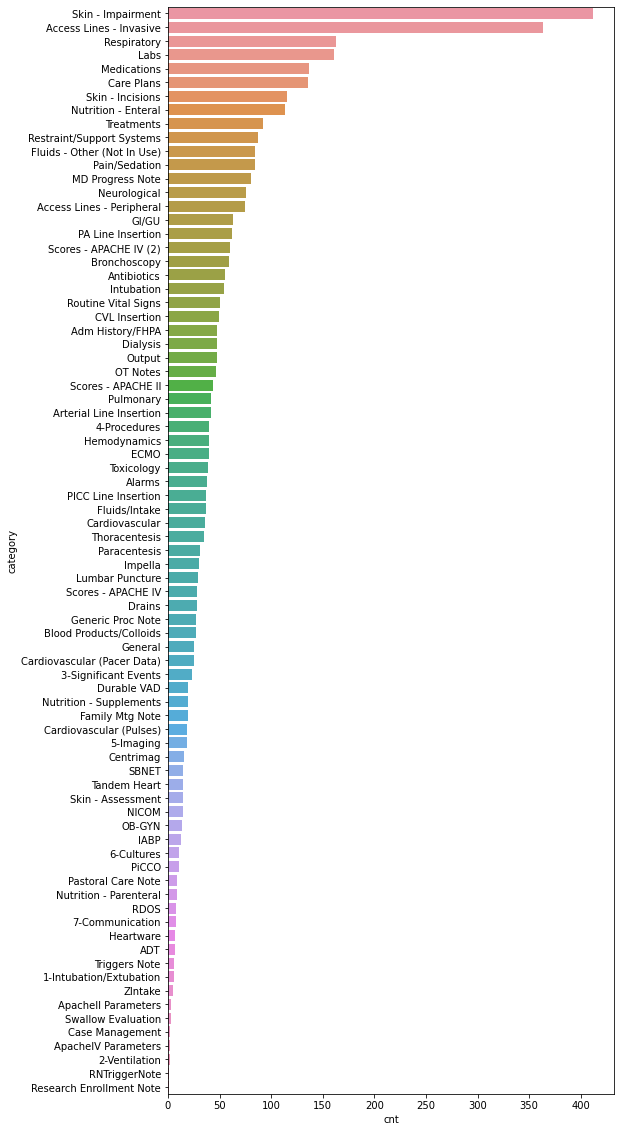

In [17]:
plt.figure(figsize=(8,20))
sns.barplot(x="cnt", y="category", data=itemCategoriesDf)

# Routine vital signs

In [19]:
routineVitalSignsQuery = query_schema + \
"""
SELECT
itm.itemid, 
itm.label, 
itm.abbreviation, 
itm.param_type 
FROM mimiciv.d_items itm
WHERE itm.category = 'Routine Vital Signs'
"""

routineVitalSignsDf = pd.read_sql_query(routineVitalSignsQuery, con)
routineVitalSignsDf

,itemid,label,abbreviation,param_type
0,220045,Heart Rate,HR,Numeric
1,220048,Heart Rhythm,Heart Rhythm,Text
2,220050,Arterial Blood Pressure systolic,ABPs,Numeric
3,220051,Arterial Blood Pressure diastolic,ABPd,Numeric
4,220052,Arterial Blood Pressure mean,ABPm,Numeric
5,220179,Non Invasive Blood Pressure systolic,NBPs,Numeric
6,220180,Non Invasive Blood Pressure diastolic,NBPd,Numeric
7,220181,Non Invasive Blood Pressure mean,NBPm,Numeric
8,224359,QTc,QTc,Numeric
9,223761,Temperature Fahrenheit,Temperature F,Numeric


# Routine vital signs with > 80% coverage

In [29]:
top_vitals = ["heart_rate", "respiratory_rate", "o_saturation_pulseoxymetry", "heart_rhythm", "gcs_eye_opening", "gcs_verbal_response", "gcs_motor_response", "alarms_on", "head_of_bed", "rul_lung_sounds", "lul_lung_sounds", "temperature_site", "heart_rate_alarm_low", "heart_rate_alarm_high", "rll_lung_sounds", "turn", "lll_lung_sounds", "parameters_checked", "o_saturation_pulseoxymetry_alarm_low", "o_saturation_pulseoxymetry_alarm_high", "resp_alarm_high", "resp_alarm_low", "abdominal_assessment", "skin_integrity", "skin_temperature", "oral_cavity", "skin_condition", "bowel_sounds", "activity_tolerance", "skin_color", "pain_present", "braden_sensory_perception", "braden_mobility", "braden_moisture", "braden_activity", "braden_nutrition", "braden_friction_shear", "non_invasive_blood_pressure_mean", "non_invasive_blood_pressure_systolic", "non_invasive_blood_pressure_diastolic", "spo_desat_limit", "o_delivery_device_s_", "temperature_fahrenheit", "diet_type", "urine_source", "edema_location", "position", "dorsal_pedpulse_r", "dorsal_pedpulse_l", "iv_saline_lock", "gait_transferring", "ambulatory_aid", "mental_status", "secondary_diagnosis", "history_of_falling_within_mnths_", "ectopy_type__x", "sodium_serum_", "potassium_serum_", "chloride_serum_", "creatinine_serum_", "bun", "hco_serum_", "anion_gap", "hematocrit_serum_", "glucose_serum_", "hemoglobin", "platelet_count", "wbc", "pain_location", "cough_effort", "non_invasive_blood_pressure_alarm_low", "non_invasive_blood_pressure_alarm_high", "magnesium", "nbp_alarm_source", "urine_color", "education_learner", "education_topic", "education_barrier", "education_method", "education_response", "urine_appearance", "side_rails_x", "safety_measures", "admission_weight_kg_", "phosphorous", "calcium_non_ionized", "posttib_pulses_r", "posttib_pulses_l", "pain_level_acceptable", "pain_level", "support_systems", "pupil_size_right", "pupil_size_left", "pain_management", "pupil_response_right", "pupil_response_left", "pain_type", "rle_temp", "lle_temp", "rle_color", "anti_embolic_device", "lle_color", "rue_temp", "lue_temp", "rue_color", "lue_color", "richmond_ras_scale", "nares_r", "nares_l", "pain_assessment_method_x", "cough_type", "prothrombin_time", "inr", "ptt", "capillary_refill_r", "oral_care", "capillary_refill_l", "admission_weight_lbs_", "all_medications_tolerated_without_adverse_side_effects", "family_communication", "pain_cause", "anti_embolic_device_status"]

In [41]:
itemidQuery = query_schema + \
"""
SELECT
itm.itemid,
itm.label
FROM mimiciv.chartevents cev
INNER JOIN mimiciv.d_items itm
ON itm.itemid = cev.itemid
WHERE itm.category = 'Routine Vital Signs'
GROUP BY itm.itemid
"""

itemidsDf = pd.read_sql_query(itemidQuery, con)

itemIds = []
labels = []

for itemid in itemidsDf['itemid']:
    lbl = re.sub("[^a-zA-Z]+", "_", str(itemidsDf.loc[itemidsDf['itemid'] == itemid, 'label'].values[0])).lower()
    if lbl in top_vitals:
        itemIds.append(itemid)
        labels.append(lbl)

In [44]:
itemIds

[220045, 220048, 220179, 220180, 220181, 223761, 224642]

In [43]:
labels

['heart_rate',
 'heart_rhythm',
 'non_invasive_blood_pressure_systolic',
 'non_invasive_blood_pressure_diastolic',
 'non_invasive_blood_pressure_mean',
 'temperature_fahrenheit',
 'temperature_site']

In [47]:
routineTopVitalSignsQuery = query_schema + \
"""
SELECT
itm.itemid, 
itm.label, 
itm.abbreviation, 
itm.param_type 
FROM mimiciv.d_items itm
WHERE itm.itemid IN (220045, 220048, 220179, 220180, 220181, 223761, 224642)
"""

routineTopVitalSignsDf = pd.read_sql_query(routineTopVitalSignsQuery, con)
routineTopVitalSignsDf

,itemid,label,abbreviation,param_type
0,220045,Heart Rate,HR,Numeric
1,220048,Heart Rhythm,Heart Rhythm,Text
2,220179,Non Invasive Blood Pressure systolic,NBPs,Numeric
3,220180,Non Invasive Blood Pressure diastolic,NBPd,Numeric
4,220181,Non Invasive Blood Pressure mean,NBPm,Numeric
5,223761,Temperature Fahrenheit,Temperature F,Numeric
6,224642,Temperature Site,Temp Site,Text
